# Prescriptive Analytics Project, Winter Term 2024/25

**Group members**:

- Marius Bernahrndt

- Caroline Jungheim

- Simon Scholz

- Christian Gewehr

### Table of Contents
1. [Question 1](#Question1)
2. [Question 2](#Question2)
3. [Question 3](#Question3)
4. [Question 4](#Question4)
5. [Question 5](#Question5)

## Imports

In [4]:
conda install -c gurobi gurobi

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.1.1



## Package Plan ##

  environment location: /Users/christiangewehr/anaconda3

  added / updated specs:
    - gurobi


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gurobi-12.0.1              |          py311_0        36.2 MB  gurobi
    ------------------------------------------------------------
                                           Total:        36.2 MB

The following packages will be UPDATED:

  gurobi                                     12.0.0-py311_0 --> 12.0.1-py311_0 



                                                         

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import gurobipy as gp
from gurobipy import GRB

## Question 1 <a name="Question1"></a>

In [6]:
# Load dataset
df = pd.read_csv("/Users/christiangewehr/Desktop/Prescriptive/Project_Data.csv", sep=";", index_col="index")
df.head()

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14
index,,,,,,,,,,,,,,
1,1,2,0,1,0,0,2,1,1,2,1,0,0,1
2,1,1,0,1,0,0,2,1,2,2,1,0,0,1
3,1,1,0,1,0,0,2,1,2,2,1,0,0,1
4,1,1,0,1,0,0,2,1,0,2,1,0,0,1
5,1,2,0,1,0,0,2,1,1,2,1,0,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1 to 168
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Week 1   168 non-null    int64
 1   Week 2   168 non-null    int64
 2   Week 3   168 non-null    int64
 3   Week 4   168 non-null    int64
 4   Week 5   168 non-null    int64
 5   Week 6   168 non-null    int64
 6   Week 7   168 non-null    int64
 7   Week 8   168 non-null    int64
 8   Week 9   168 non-null    int64
 9   Week 10  168 non-null    int64
 10  Week 11  168 non-null    int64
 11  Week 12  168 non-null    int64
 12  Week 13  168 non-null    int64
 13  Week 14  168 non-null    int64
dtypes: int64(14)
memory usage: 19.7 KB


As we have 168 hours in a week (24 hours × 7 days = 168), we interpret the index as an ‘hour index’. From this we calculate the day (1-7) and the hour of the day (0-23).

In [8]:
# Convert DataFrame to long form: convert week columns into a ‘Week’ column
df_melt = df.reset_index().melt(
    id_vars="index",
    var_name="Week",
    value_name="PhysiciansNeeded"
)

# Rename hour index and split into day and hour of day
df_melt.rename(columns={"index": "HourIndex"}, inplace=True)
df_melt["DayOfWeek"] = (df_melt["HourIndex"] - 1) // 24 + 1
df_melt["HourOfDay"] = (df_melt["HourIndex"] - 1) % 24

In [9]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HourIndex         2352 non-null   int64 
 1   Week              2352 non-null   object
 2   PhysiciansNeeded  2352 non-null   int64 
 3   DayOfWeek         2352 non-null   int64 
 4   HourOfDay         2352 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 92.0+ KB


In [10]:
df_melt.head()

,HourIndex,Week,PhysiciansNeeded,DayOfWeek,HourOfDay
0,1,Week 1,1,1,0
1,2,Week 1,1,1,1
2,3,Week 1,1,1,2
3,4,Week 1,1,1,3
4,5,Week 1,1,1,4


In [11]:
# Define shifts
#    night:  0-7
#    early:  8-15
#    late:   16-23
def assign_shift(h):
    if 0 <= h < 8:
        return "night"
    elif 8 <= h < 16:
        return "early"
    else:
        return "late"

df_melt["Shift"] = df_melt["HourOfDay"].apply(assign_shift)

In [12]:
df_melt

,HourIndex,Week,PhysiciansNeeded,DayOfWeek,HourOfDay,Shift
0,1,Week 1,1,1,0,night
1,2,Week 1,1,1,1,night
2,3,Week 1,1,1,2,night
3,4,Week 1,1,1,3,night
4,5,Week 1,1,1,4,night
...,...,...,...,...,...,...
2347,164,Week 14,2,7,19,late
2348,165,Week 14,1,7,20,late
2349,166,Week 14,1,7,21,late
2350,167,Week 14,1,7,22,late


#### Explorative analyses and visualisations

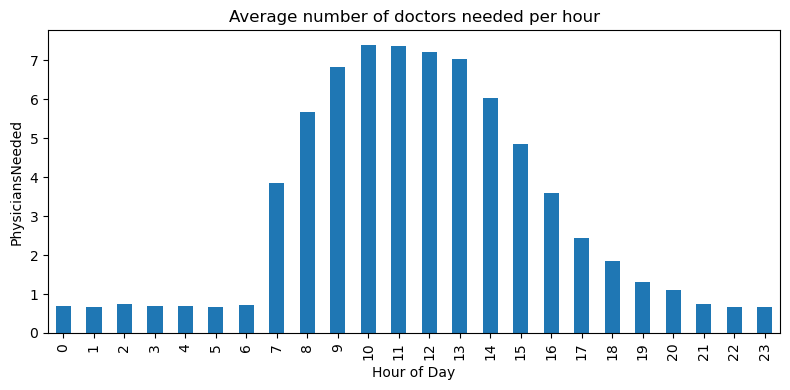

In [13]:
# Required Physicians on average per hour of the day
avg_by_hour = df_melt.groupby("HourOfDay")["PhysiciansNeeded"].mean()

plt.figure(figsize=(8, 4))
avg_by_hour.plot(kind="bar")
plt.title("Average number of doctors needed per hour")
plt.xlabel("Hour of Day")
plt.ylabel("PhysiciansNeeded")
plt.tight_layout()
plt.show()

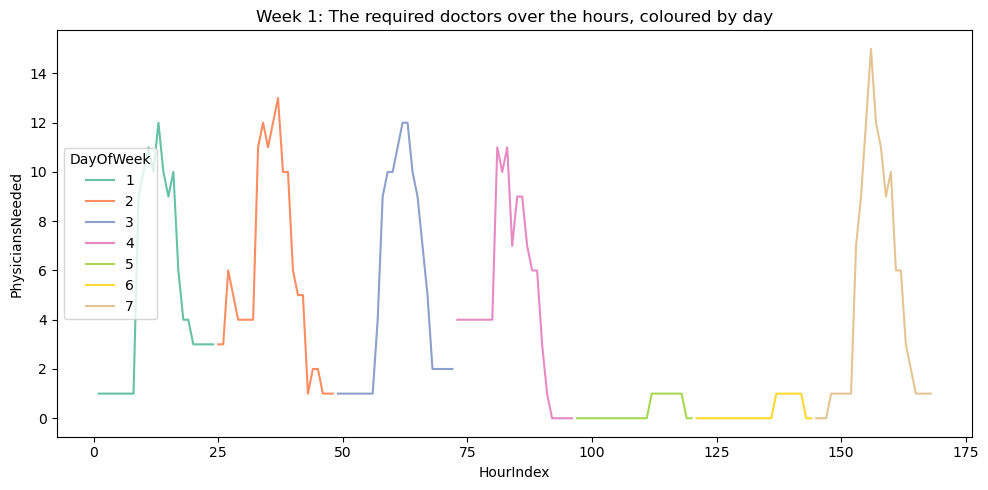

In [14]:
# The course of the 7 days in a particular week
week1_data = df_melt[df_melt["Week"] == "Week 1"]
plt.figure(figsize=(10,5))
sns.lineplot(
    data=week1_data,
    x="HourIndex",
    y="PhysiciansNeeded",
    hue="DayOfWeek",
    palette="Set2"
)
plt.title("Week 1: The required doctors over the hours, coloured by day")
plt.xlabel("HourIndex")
plt.ylabel("PhysiciansNeeded")
plt.legend(title="DayOfWeek")
plt.tight_layout()
plt.show()

/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


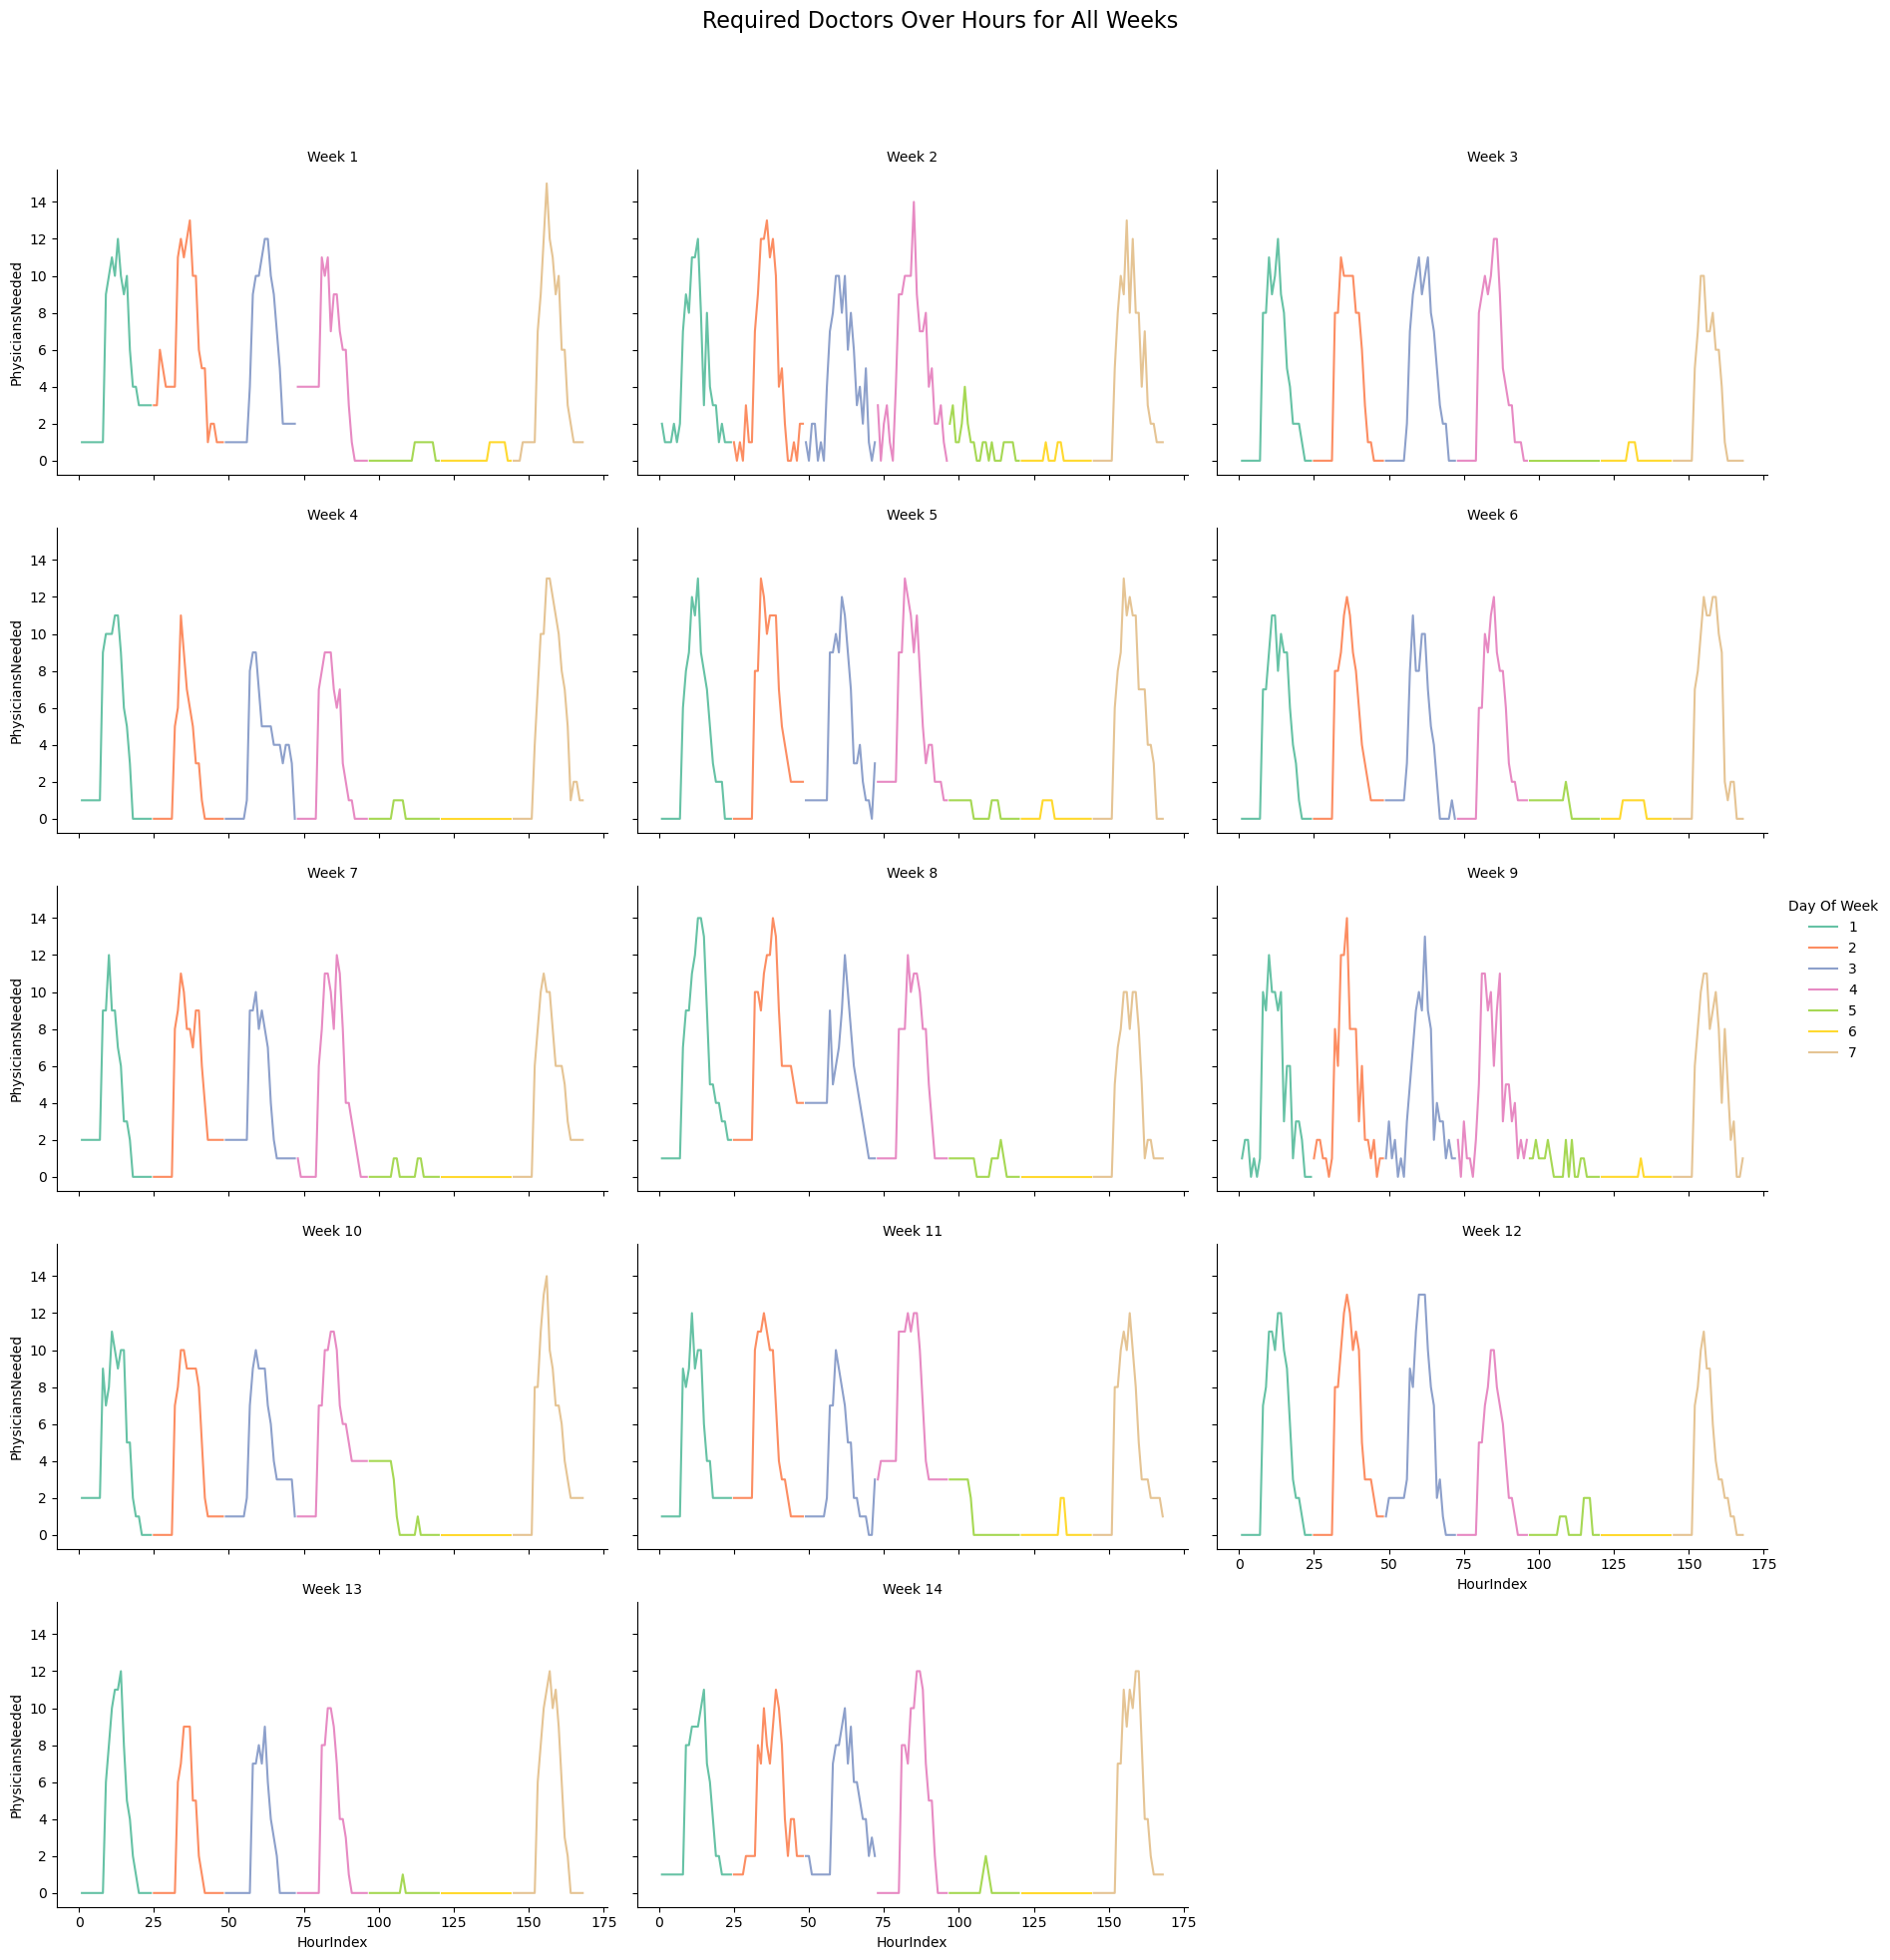

In [15]:
# The course of the 7 days over all weeks
g = sns.FacetGrid(
    df_melt,
    col="Week",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map(sns.lineplot, "HourIndex", "PhysiciansNeeded", "DayOfWeek", palette="Set2")

g.set_titles("{col_name}")
g.set_axis_labels("HourIndex", "PhysiciansNeeded")
g.add_legend(title="Day Of Week")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Required Doctors Over Hours for All Weeks", fontsize=16)
plt.show()

We can see that the required power on days 5 and 6 is the same and behaves differently from the other days. For this reason, we can assume that it is the weekend of Saturday and Sunday. The data set therefore begins on a Tuesday.

In [16]:
# Map Weekdays
days_dict = {
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
    7: "Monday",
}

df_melt["DayName"] = df_melt["DayOfWeek"].map(days_dict)

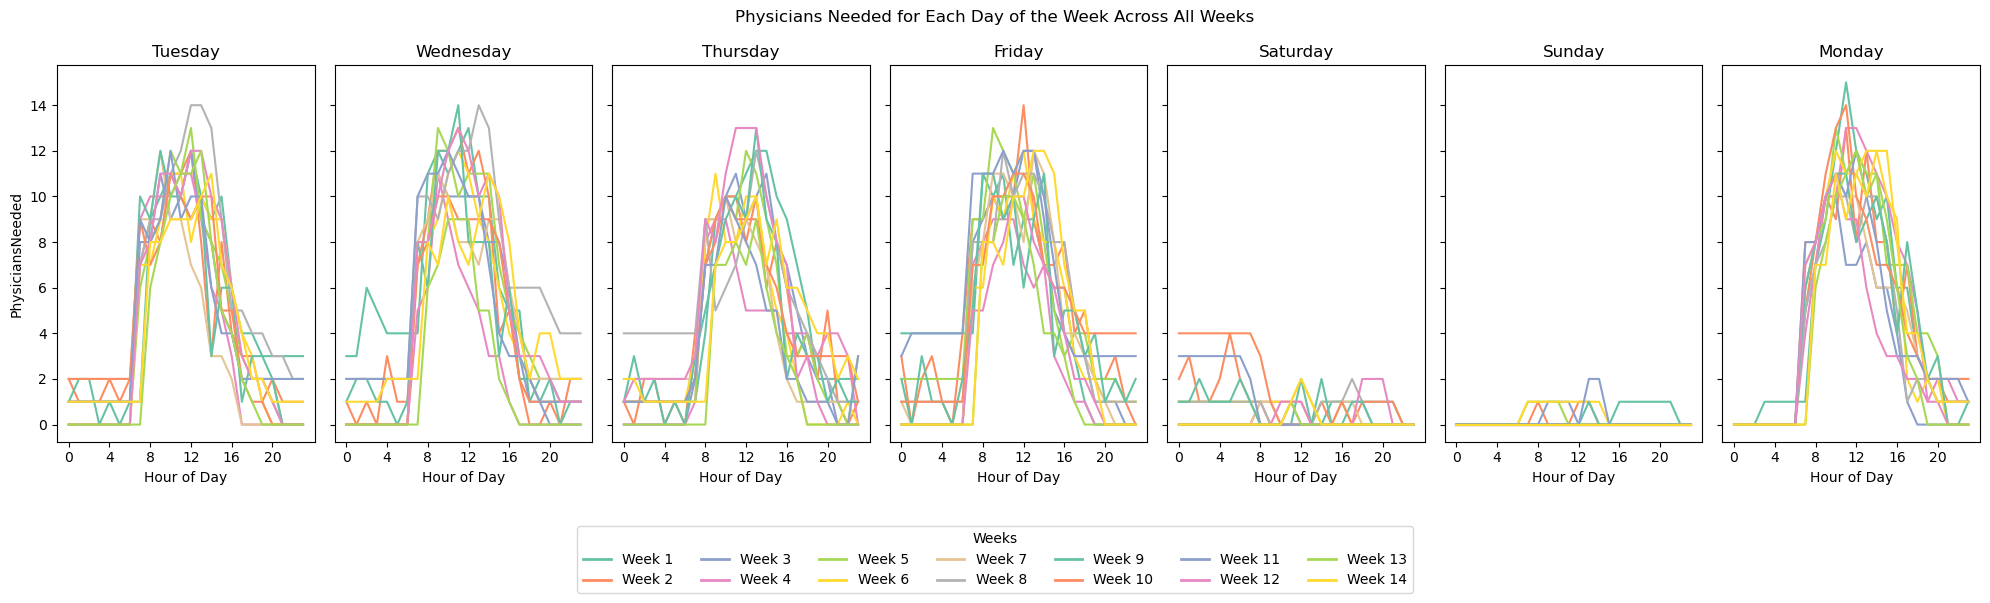

In [17]:
# Physicians Needed for Each Day of the Week Across All Weeks
week_labels = df_melt["Week"].unique()
fig, axes_line = plt.subplots(1, 7, figsize=(20, 5), sharey=True)

colours = sns.color_palette("Set2", n_colors=len(week_labels))

for i, day_num in enumerate(sorted(days_dict.keys())):
    day_name = days_dict[day_num]
    df_daily = df_melt[df_melt["DayName"] == day_name]

    for j, w_label in enumerate(week_labels):
        df_week = df_daily[df_daily["Week"] == w_label]

        sns.lineplot(
            x="HourOfDay",
            y="PhysiciansNeeded",
            data=df_week,
            color=colours[j],
            ax=axes_line[i],
        )

    axes_line[i].set_title(f"{day_name}")
    if i == 0:
        axes_line[i].set_ylabel("PhysiciansNeeded")
    else:
        axes_line[i].set_ylabel("")
    axes_line[i].set_xlabel("Hour of Day")
    axes_line[i].set_xticks(range(0,24,4))
    axes_line[i].set_xticklabels(range(0,24,4))

handles = [
    plt.Line2D([0], [0], color=colours[i], lw=2, label=week_labels[i])
    for i in range(len(week_labels))
]
fig.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    title="Weeks"
)

plt.suptitle("Physicians Needed for Each Day of the Week Across All Weeks")
plt.tight_layout()
plt.show()

In [18]:
# Mean, Median, STD, Min, Max
# Per Shift
stats_by_shift = df_melt.groupby("Shift")["PhysiciansNeeded"].agg(
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max"
).reset_index()

print("\nStatistical key figures per shift (all weeks/days together):")
print(stats_by_shift)


Statistical key figures per shift (all weeks/days together):
   Shift      mean  median       std  min  max
0  early  6.545918     8.0  4.434042    0   15
1   late  1.544643     1.0  1.870125    0    9
2  night  1.093112     0.0  1.905227    0   11


In [19]:
# Per Day and Shift
stats_by_day_shift = df_melt.groupby(["DayName", "Shift"])["PhysiciansNeeded"].agg(
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max"
).reset_index()

print("\n--- Statistical key figures per (Day, Shift) ---")
print(stats_by_day_shift)


--- Statistical key figures per (Day, Shift) ---
      DayName  Shift      mean  median       std  min  max
0      Friday  early  9.062500     9.0  2.182160    3   14
1      Friday   late  2.125000     2.0  1.959615    0    8
2      Friday  night  1.705357     1.0  2.399844    0   11
3      Monday  early  9.464286    10.0  2.151591    3   15
4      Monday   late  2.312500     2.0  2.160377    0    9
5      Monday  night  0.642857     0.0  1.859270    0    8
6    Saturday  early  0.348214     0.0  0.595929    0    3
7    Saturday   late  0.232143     0.0  0.501927    0    2
8    Saturday  night  0.937500     0.5  1.254048    0    4
9      Sunday  early  0.187500     0.0  0.435606    0    2
10     Sunday   late  0.053571     0.0  0.226182    0    1
11     Sunday  night  0.017857     0.0  0.133027    0    1
12   Thursday  early  8.321429     9.0  2.286720    0   13
13   Thursday   late  2.267857     2.0  1.926497    0    9
14   Thursday  night  1.267857     1.0  1.114864    0    4
15    

In [20]:
# Differentiate between weekday and weekend
weekday_mapping = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
df_melt["is_weekday"] = df_melt["DayName"].map(lambda x: 1 if weekday_mapping[x] <= 5 else 0)

df_weekday = df_melt[df_melt["is_weekday"] == 1]
df_weekend = df_melt[df_melt["is_weekday"] == 0]
print(f"Working day entries: {len(df_weekday)} | Weekend entries: {len(df_weekend)}")

Working day entries: 1680 | Weekend entries: 672


#### Clustering

In [21]:
# Prepare Columns and create Shifts
df_day_shift = df_melt.groupby(["Week", "DayName", "Shift"])["PhysiciansNeeded"].mean().reset_index()

df_day_shift_pivot = df_day_shift.pivot_table(
    index=["Week", "DayName"],
    columns="Shift",
    values="PhysiciansNeeded"
).reset_index()

df_day_shift_pivot = df_day_shift_pivot[["Week", "DayName", "night", "early", "late"]]

print("\n(Week, DayName) -> night/early/late:")
display(df_day_shift_pivot.head(10))


(Week, DayName) -> night/early/late:


Shift,Week,DayName,night,early,late
0,Week 1,Friday,4.000,8.750,1.250
1,Week 1,Monday,0.625,10.625,2.625
2,Week 1,Saturday,0.000,0.125,0.750
3,Week 1,Sunday,0.000,0.000,0.750
4,Week 1,Thursday,1.000,9.750,3.875
5,Week 1,Tuesday,1.000,10.125,3.625
6,Week 1,Wednesday,4.125,10.625,2.250
7,Week 10,Friday,1.750,9.000,4.375
8,Week 10,Monday,1.000,9.875,2.875
9,Week 10,Saturday,4.000,0.500,0.125


In [22]:
# Standardize the data
shift_cols = ["night", "early", "late"]
X = df_day_shift_pivot[shift_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

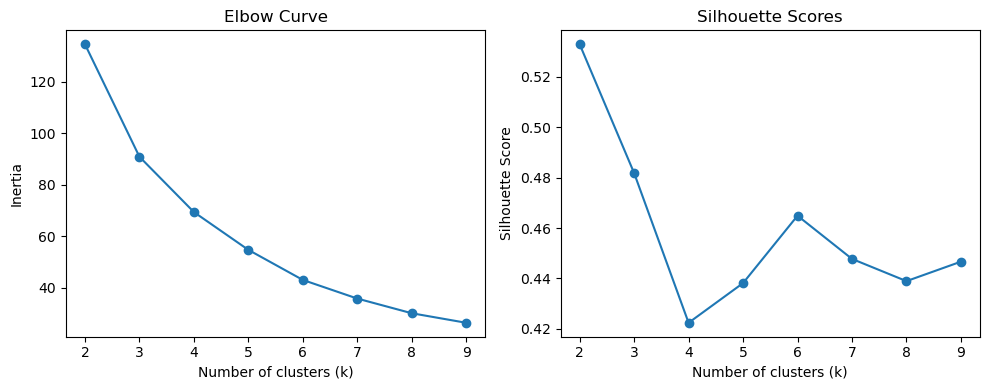


Elbow-Scores: [134.58248344345733, 90.8954864610256, 69.40756026993517, 54.72292914088226, 43.04613108042855, 35.812312128673696, 30.109806156943492, 26.40297435124306]
Silhouette-Scores: [0.5328908740353441, 0.48179413736908194, 0.4224040588211259, 0.4381502835653222, 0.4648783603064874, 0.4477434874355891, 0.43893309188324536, 0.4466528526064737]


In [23]:
# Elbow + Silhouette to decide how many Clusters there are
K_range = range(2, 10)
inertia_list = []
silhouette_list = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    inertia_list.append(km.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_list.append(sil_score)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_list, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")

plt.tight_layout()
plt.show()

print("\nElbow-Scores:", inertia_list)
print("Silhouette-Scores:", silhouette_list)

The elbow method is used to determine the optimum number of clusters by identifying the point at which a further reduction in inertia no longer brings any significant improvement. In this case, there is no clear kink in the elbow curve, which is why the silhouette score is also used, which evaluates the cluster quality based on the highest possible value. The combination of both approaches shows that **k=3** offers the best balance between low inertia and high cluster quality, which is why the analysis is continued with 3 clusters.

In [24]:
# Cluster with best k from elbow method
best_k = 3

kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df_day_shift_pivot["Cluster"] = kmeans_final.fit_predict(X_scaled)

print(f"\n--- Final Cluster Assignment (k={best_k}) ---")
df_day_shift_pivot


--- Final Cluster Assignment (k=3) ---


/Users/christiangewehr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shift,Week,DayName,night,early,late,Cluster
0,Week 1,Friday,4.000,8.750,1.250,2
1,Week 1,Monday,0.625,10.625,2.625,1
2,Week 1,Saturday,0.000,0.125,0.750,0
3,Week 1,Sunday,0.000,0.000,0.750,0
4,Week 1,Thursday,1.000,9.750,3.875,1
...,...,...,...,...,...,...
93,Week 9,Saturday,1.250,0.500,0.250,0
94,Week 9,Sunday,0.000,0.125,0.000,0
95,Week 9,Thursday,1.375,8.750,2.125,1
96,Week 9,Tuesday,2.125,8.625,1.875,2


In [25]:
# Map cluster to dataset
cluster_dict = df_day_shift_pivot.set_index(["Week", "DayName"])["Cluster"].to_dict()

def map_cluster(row):
    return cluster_dict.get((row["Week"], row["DayName"]), np.nan)

df_melt["Cluster"] = df_melt.apply(map_cluster, axis=1)

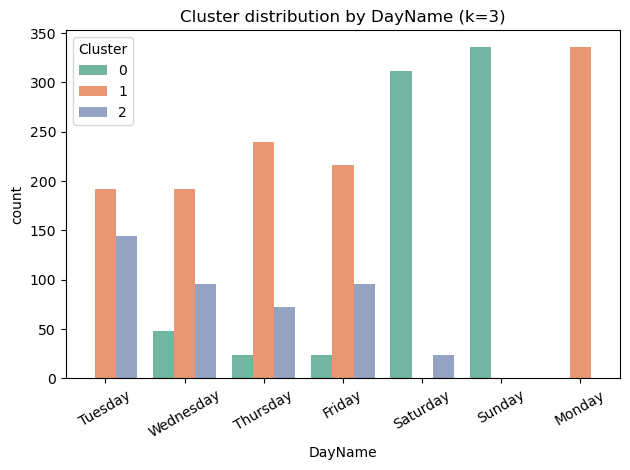

In [26]:
# Countplot
sns.countplot(
    x="DayName",
    hue="Cluster",
    data=df_melt,
    palette="Set2"
)
plt.title(f"Cluster distribution by DayName (k={best_k})")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

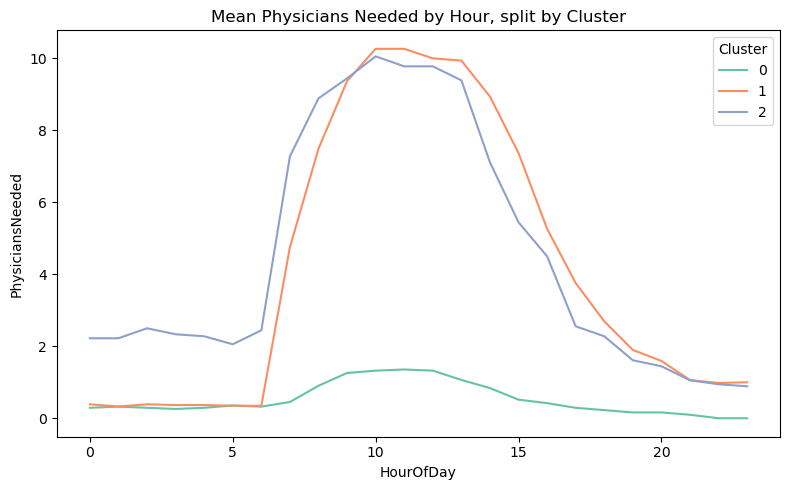

In [27]:
# Lineplot
df_cluster_agg = df_melt.groupby(["Cluster","HourOfDay"])["PhysiciansNeeded"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(
    x="HourOfDay",
    y="PhysiciansNeeded",
    hue="Cluster",
    data=df_cluster_agg,
    palette="Set2"
)
plt.title("Mean Physicians Needed by Hour, split by Cluster")
plt.xlabel("HourOfDay")
plt.ylabel("PhysiciansNeeded")
plt.tight_layout()
plt.show()

In [28]:
# Mean, median, standard deviation, maximum and minimum for each shift type in each cluster
stats_by_cluster_shift = (
    df_melt.groupby(["Cluster", "Shift"])["PhysiciansNeeded"]
    .agg(["mean", "median", "std", "max", "min"])
    .reset_index()
)

print(stats_by_cluster_shift)

   Cluster  Shift      mean  median       std  max  min
0        0  early  1.072581     0.0  2.350548   11    0
1        0   late  0.169355     0.0  0.479908    3    0
2        0  night  0.322581     0.0  0.769335    5    0
3        1  early  9.204082     9.0  2.087396   15    1
4        1   late  2.280612     2.0  1.951544    9    0
5        1  night  0.910714     0.0  1.845625    8    0
6        2  early  8.736111     9.0  3.168874   14    0
7        2   late  1.909722     1.0  1.854547    8    0
8        2  night  2.916667     2.0  2.251651   11    0


### Cluster Interpretation

1. **Cluster 0** – **High Demand**
   - **Early Shift (mean ~9.23, max 15)** stands out with the highest requirement.
   - **Night (1.05) and Late (2.30)** remain moderate.

>**Insight**: Typical weekday pattern with a significant daytime (early) demand, e.g., for scheduled surgeries or consultations.

2. **Cluster 1** – **Low Demand**
   - Consistently low values in **night (0.24), early (1.11),** and **late (0.18)**.
   - Often zero-demand in many observations (min = 0 for all shifts).

> **Insight**: Likely **weekend-like days** or otherwise very quiet days with minimal staffing needs across all shifts.

3. **Cluster 2** – **Medium Demand**
   - **Night** is noticeably higher at **3.24** on average, while **Early** remains at **7.74** (less than Cluster 0, but still considerable).
   - **Late** shift stands at **1.51**.

> **Insight**: Days with **increased night demand** (e.g., emergencies or on-call duties) but not the maximum early shift requirement seen in Cluster 0.


### Weekend and Weekday

By reviewing the `DayName` column (e.g., Monday, Tuesday, etc.), **Saturdays and Sundays** most frequently fall into **Cluster 1**, aligning with very low values across all shifts. This confirms that weekends tend to require fewer physicians. In contrast, **Mondays and other weekdays** often appear in Cluster 0 or 2, reflecting higher overall demand—especially during the early shift and, for Cluster 2, an elevated night demand.


### Conclusion

- **Cluster 1**: Minimal demand in every shift — a clear weekend signature.
- **Cluster 0**: Significant peaks in the early shift, representing typical busy weekdays.
- **Cluster 2**: Notably higher night requirements alongside a substantial (but not maximum) early shift demand.

These three clusters allow us to categorize the days based on staffing needs for each shift. Such insights can guide more targeted physician scheduling, ensuring sufficient coverage especially on high-demand weekdays (Cluster 0) and special night-demand days (Cluster 2) while recognizing that certain days (Cluster 1) require minimal staffing.


## Question 2 <a name="Question2"></a>

## Mathematical Model Description

### Variables:
1. $x[p, d, s] ∈ {0,1}$: Binary decision variable, where:
   - $x[p, d, s] = 1$ if physician $p$ works shift $s$ on day $d$.
   - $x[p, d, s] = 0$ otherwise.

2. $y[p] ∈ {0,1}$: Binary variable indicating whether physician $p$ is used at all:
   - $y[p] = 1$ if $p$ is assigned any shifts during the week.
   - $y[p] = 0$ otherwise.

3. $b[p, s] ∈ {0,1}$: Binary variable for shift-type allocation:
   - $b[p, s] = 1$ if physician $p$ is allowed to work shift type $s$ in the week.
   - Each physician can only work two shift types.

4. ${day\_worked}[p, d] ∈ {0,1}$: Auxiliary variable to track whether physician $p$ works on day $d$.

5. $z[p, d] ∈ {0,1}$: Binary variable to enforce two consecutive days off:
   - $z[p, d] = 1$ if physician $p$ has both day $d$ and $d+1$ off.
   - $z[p, d] = 0$ otherwise.

---

### Objective:
Minimize the total number of physicians:
$$\[
\text{Minimize: } \sum_{p} y[p]
\]$$

---

### Constraints:
1. **Demand Satisfaction**:
   - Ensure that demand for each day and shift is met:
   $$\[
   \sum_{p} x[p, d, s] \geq \text{demand}[d, s], \, \forall d, s
   \]$$

2. **40-Hour Weekly Limit**:
   - Each physician can work at most 5 shifts per week:
   $$\[
   \sum_{d, s} x[p, d, s] \leq 5, \, \forall p
   \]$$

3. **Two Shift Types Per Week**:
   - Physicians are restricted to at most two shift types:
   $$\[
   \sum_{s} b[p, s] = 2, \, \forall p
   \]$$
   $$\[
   x[p, d, s] \leq b[p, s], \, \forall p, d, s
   \]$$

4. **No More Than 3 Consecutive Night Shifts**:
   - For every 4 consecutive days, no more than 3 night shifts:
   $$\[
   \sum_{d' \in \{d, d+1, d+2, d+3\}} x[p, d', \text{Night}] \leq 3, \, \forall p, d
   \]$$

5. **10-Hour Rest Requirement**:
   - Late shift on day $d$ prevents an early shift on day $d+1$:
   $$\[
   x[p, d, \text{Late}] + x[p, d+1, \text{Early}] \leq 1, \, \forall p, d
   \]$$

6. **Two Consecutive Days Off**:
   - Ensure each physician has at least one pair of consecutive days off:
   $$\[
   \sum_{d} z[p, d] \geq 1, \, \forall p
   \]$$
   Where:
   $$\[
   z[p, d] \leq 1 - {day\_worked}[p, d] \, \forall p, d
   \]$$
   $$\[
   z[p, d] \leq 1 - {day\_worked}[p, d+1] \, \forall p, d
   \]$$


Average demand per shift per day:
Shift         early      late     night
DayName                                
Tuesday    9.169643  1.767857  1.517857
Wednesday  9.267857  2.053571  1.562500
Thursday   8.321429  2.267857  1.267857
Friday     9.062500  2.125000  1.705357
Saturday   0.348214  0.232143  0.937500
Sunday     0.187500  0.053571  0.017857
Monday     9.464286  2.312500  0.642857


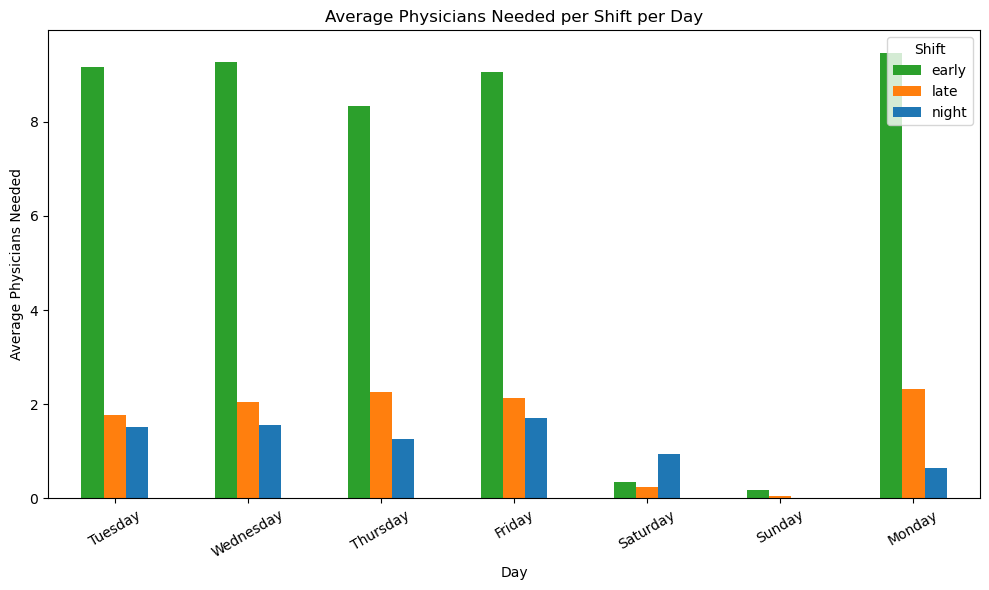

In [29]:
# Mean values from stats_by_day_shift
day_order = list(days_dict.values())

avg_shift_day = stats_by_day_shift.pivot(
    index="DayName",
    columns="Shift",
    values="mean"
)

avg_shift_day = avg_shift_day.reindex(day_order)

print("Average demand per shift per day:")
print(avg_shift_day)

# Colors for shifts
shift_colors = {"Night": "#1f77b4", "Early": "#2ca02c", "Late": "#ff7f0e"}

# Barplot
avg_shift_day.plot(
    kind="bar",
    figsize=(10, 6),
    color=[shift_colors["Early"], shift_colors["Late"], shift_colors["Night"]]
)
plt.title("Average Physicians Needed per Shift per Day")
plt.ylabel("Average Physicians Needed")
plt.xlabel("Day")
plt.xticks(rotation=30)
plt.legend(title="Shift")
plt.tight_layout()
plt.show()

In [30]:
# demand = {
#     'Tuesday': {'Early': 9, 'Late': 2, 'Night': 2},
#     'Wednesday': {'Early': 9, 'Late': 2, 'Night': 2},
#     'Thursday': {'Early': 8, 'Late': 2, 'Night': 1},
#     'Friday': {'Early': 9, 'Late': 2, 'Night': 2},
#     'Saturday': {'Early': 0, 'Late': 0, 'Night': 1},
#     'Sunday': {'Early': 0, 'Late': 0, 'Night': 0},
#     'Monday': {'Early': 9, 'Late': 2, 'Night': 1},
# }

# Perhaps we should use this demand because personal can only round up ???
demand = {
    'Tuesday': {'Early': 10, 'Late': 2, 'Night': 2},
    'Wednesday': {'Early': 10, 'Late': 3, 'Night': 2},
    'Thursday': {'Early': 9, 'Late': 3, 'Night': 2},
    'Friday': {'Early': 10, 'Late': 3, 'Night': 2},
    'Saturday': {'Early': 1, 'Late': 1, 'Night': 1},
    'Sunday': {'Early': 1, 'Late': 1, 'Night': 1},
    'Monday': {'Early': 10, 'Late': 3, 'Night': 1},
}

Here, we first calculated the averages to determine how many physicians are needed per day and shift. The demand, rounded to the nearest integer, was then stored in a dictionary, providing a clear and practical representation of physician requirements for scheduling.

In [31]:
def physician_scheduling(physicians, demand, DAYS, SHIFTS):
    m = gp.Model("PhysicianScheduling")

    # Decision variables
    x = m.addVars(physicians, DAYS, SHIFTS, vtype=GRB.BINARY, name="x")
    y = m.addVars(physicians, vtype=GRB.BINARY, name="y")
    b = m.addVars(physicians, SHIFTS, vtype=GRB.BINARY, name="b")
    day_worked = m.addVars(physicians, DAYS, vtype=GRB.BINARY, name="day_worked")
    z = m.addVars(physicians, DAYS, vtype=GRB.BINARY, name="z_consecutiveOff")

    # Objective
    m.setObjective(gp.quicksum(y[p] for p in physicians), GRB.MINIMIZE)

    # Constraints
    # 1. Demand Satisfaction
    for d in DAYS:
        for s in SHIFTS:
            m.addConstr(
                gp.quicksum(x[p, d, s] for p in physicians) >= demand[d][s],
                name=f"demand_{d}_{s}"
            )
            m.addConstr(
                gp.quicksum(x[p, d, s] for p in physicians) >= 1,
                name=f"at_least_one_per_shift_{d}_{s}"
            )

    # Ensure y[p] is 1 if physician p works any shift
    for p in physicians:
        m.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5 * y[p],
            name=f"activate_y_{p}"
        )

    # 2. 40-Hour Weekly Limit
    for p in physicians:
        m.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5,
            name=f"max_shifts_{p}"
        )

    # 3. Two Shift Types Per Week
    for p in physicians:
        m.addConstr(
            gp.quicksum(b[p, s] for s in SHIFTS) <= 2,
            name=f"max_shift_types_{p}"
        )
        for d in DAYS:
            for s in SHIFTS:
                m.addConstr(
                    x[p, d, s] <= b[p, s],
                    name=f"shift_type_assignment_{p}_{d}_{s}"
                )

    # 4. No More Than 3 Consecutive Night Shifts (including cyclic transition)
    for p in physicians:
        for i in range(len(DAYS) - 3):
            m.addConstr(
                gp.quicksum(x[p, DAYS[i + j], "Night"] for j in range(4)) <= 3,
                name=f"Max3ConsecutiveNights_p{p}_start{i}"
            )
        # Cyclic transition: Friday -> Monday
        m.addConstr(
            gp.quicksum(x[p, day, "Night"] for day in ["Friday", "Saturday", "Sunday", "Monday"]) <= 3,
            name=f"Max3ConsecutiveNights_cyclic_p{p}"
        )
        # m.addConstr(
        #     gp.quicksum(x[p, d, "Night"] for d in DAYS) <= 3,
        #     name=f"Max3NightShifts_per_week_p{p}"
        # )

    # 5. 10-Hour Rest Requirement (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS)):
            # Maximum one shift per day
            m.addConstr(
                gp.quicksum(x[p, DAYS[i], s] for s in SHIFTS) <= 1,
                name=f"max_one_shift_per_day_{p}_{DAYS[i]}"
            )

        for i in range(len(DAYS) - 1):
            # Night shift on day i -> No early shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Night"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"night_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No night shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"late_to_night_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No early shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"late_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Early shift on day i -> No night shift on the next day
            m.addConstr(
                x[p, DAYS[i], "Early"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"early_to_night_next_day_{p}_{DAYS[i]}"
            )

        # Sunday -> Monday transition
        m.addConstr(
            x[p, "Sunday", "Night"] + x[p, "Monday", "Early"] <= 1,
            name=f"night_to_early_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Night"] <= 1,
            name=f"late_to_night_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Early"] <= 1,
            name=f"late_to_early_sunday_to_monday_{p}"
        )
        m.addConstr(
            x[p, "Sunday", "Early"] + x[p, "Monday", "Night"] <= 1,
            name=f"early_to_night_sunday_to_monday_{p}"
        )

        for d in DAYS:
            m.addConstr(
                day_worked[p, d] == gp.quicksum(x[p, d, s] for s in SHIFTS),
                name=f"link_day_worked_{p}_{d}"
            )

    # 6. Two Consecutive Days Off (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS) - 1):
            m.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i]],
                name=f"day_off_constraint_{p}_{DAYS[i]}"
            )
            m.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i + 1]],
                name=f"consecutive_off_{p}_{DAYS[i]}"
            )
            m.addConstr(
                z[p, DAYS[i]] >= 1 - (day_worked[p, DAYS[i]] + day_worked[p, DAYS[i + 1]]),
                name=f"force_consecutive_off_{p}_{DAYS[i]}"
            )
        # Ensure cyclic consecutive days off between Sunday and Monday
        m.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Sunday"],
            name=f"day_off_sunday_{p}"
        )
        m.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Monday"],
            name=f"consecutive_off_sunday_monday_{p}"
        )
        m.addConstr(
            z[p, "Sunday"] >= 1 - (day_worked[p, "Sunday"] + day_worked[p, "Monday"]),
            name=f"force_consecutive_off_sunday_monday_{p}"
        )
        # At least one pair of consecutive days off
        m.addConstr(
            gp.quicksum(z[p, d] for d in DAYS) >= 1,
            name=f"at_least_one_off_pair_{p}"
        )

    # Solve the model
    m.optimize()

    return m, x, y

In [32]:

DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SHIFTS = ["Night", "Early", "Late"]
max_physicians = 21
initial_physicians = range(max_physicians)

m, x, y = physician_scheduling(initial_physicians, demand, DAYS, SHIFTS)

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 22.6.0 22H221)

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1995 rows, 819 columns and 6531 nonzeros
Model fingerprint: 0xfb70d387
Variable types: 0 continuous, 819 integer (819 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 21.0000000
Presolve removed 441 rows and 126 columns
Presolve time: 0.06s
Presolved: 1554 rows, 693 columns, 5481 nonzeros
Variable types: 0 continuous, 693 integer (693 binary)

Root relaxation: objective 1.560000e+01, 1705 iterations, 0.17 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

In [33]:
# Minimum number of physicians needed
min_physicians = sum(y[p].X for p in initial_physicians)
print(f"\nMinimum number of physicians required: {int(min_physicians)}")


Minimum number of physicians required: 16


In [34]:
# Optimize physician scheduling with the minimum required number of physicians
reduced_physicians = range(int(min_physicians))
m, x, y = physician_scheduling(reduced_physicians, demand, DAYS, SHIFTS)

print(f"\nOptimized schedule with {min_physicians} physicians.")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 22.6.0 22H221)

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1530 rows, 624 columns and 4976 nonzeros
Model fingerprint: 0x76876b51
Variable types: 0 continuous, 624 integer (624 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 341 rows and 96 columns
Presolve time: 0.06s
Presolved: 1189 rows, 528 columns, 4176 nonzeros
Variable types: 0 continuous, 528 integer (528 binary)

Root relaxation: objective 1.560000e+01, 1419 iterations, 0.12 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.60000    0  115          -   15.60000      -     - 

In [35]:
# Display the schedule
schedule_rows = []
for d in DAYS:
    for s in SHIFTS:
        assigned = [
            f"Dr {p}" for p in reduced_physicians if x[p, d, s].X > 0.5
        ]
        schedule_rows.append((d, s, assigned))
schedule_df = pd.DataFrame(schedule_rows, columns=["Day", "Shift", "Assigned"])
print(schedule_df)

          Day  Shift                                           Assigned
0      Monday  Night                                             [Dr 0]
1      Monday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...
2      Monday   Late                              [Dr 11, Dr 12, Dr 13]
3     Tuesday  Night                                      [Dr 0, Dr 14]
4     Tuesday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...
5     Tuesday   Late                                     [Dr 11, Dr 12]
6   Wednesday  Night                                      [Dr 0, Dr 14]
7   Wednesday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...
8   Wednesday   Late                              [Dr 10, Dr 11, Dr 12]
9    Thursday  Night                                     [Dr 13, Dr 14]
10   Thursday  Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 7, Dr 8, Dr ...
11   Thursday   Late                               [Dr 6, Dr 10, Dr 12]
12     Friday  Night                                     [Dr 11,

In [36]:
# Count shifts and create detailed schedule for each physician
physician_schedule = {f"Dr {p}": {"Total Shifts": 0, "Schedule": []} for p in reduced_physicians}

for d in DAYS:
    for s in SHIFTS:
        for p in reduced_physicians:
            if x[p, d, s].X > 0.5:
                physician_schedule[f"Dr {p}"]["Total Shifts"] += 1
                physician_schedule[f"Dr {p}"]["Schedule"].append((d, s))

# Create a summary DataFrame
physician_rows = []
for doctor, details in physician_schedule.items():
    physician_rows.append({
        "Doctor": doctor,
        "Total Shifts": details["Total Shifts"],
        "Schedule": details["Schedule"]
    })

physician_df = pd.DataFrame(physician_rows)
print("\n--- Physician Schedules ---")
print(physician_df)


--- Physician Schedules ---
   Doctor  Total Shifts                                           Schedule
0    Dr 0             4  [(Monday, Night), (Tuesday, Night), (Wednesday...
1    Dr 1             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
2    Dr 2             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
3    Dr 3             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
4    Dr 4             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
5    Dr 5             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
6    Dr 6             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
7    Dr 7             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
8    Dr 8             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
9    Dr 9             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
10  Dr 10             5  [(Monday, Early), (Tuesday, Early), (Wednesday...
11  Dr 11             4  [(Monday, Late), (Tuesday, Late), (Wednesday, 

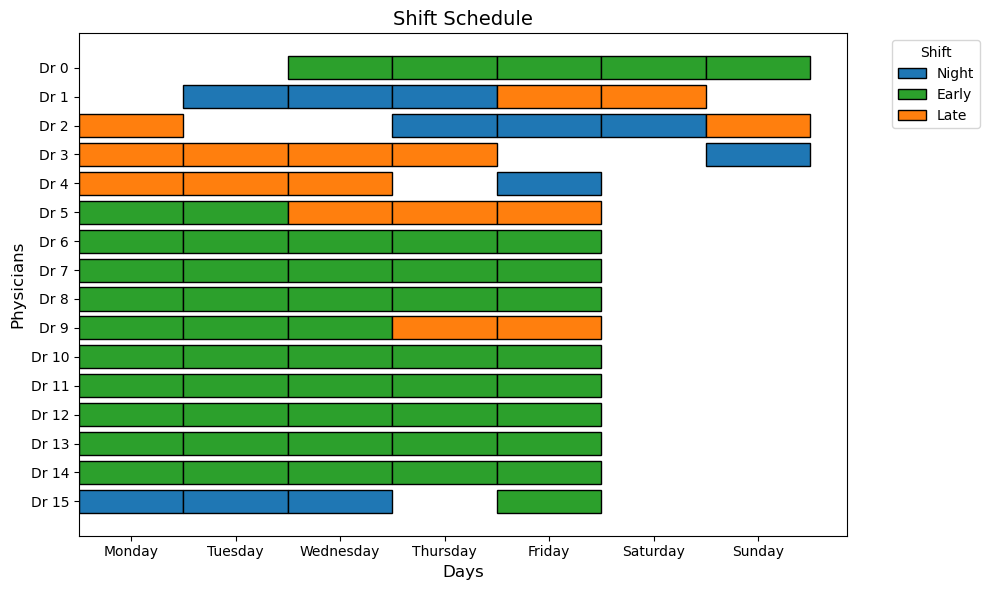

In [37]:
# Create a visual representation of the physician shift schedule
# Gantt diagramm
gantt_data = []
for p in reduced_physicians:
    for d_idx, d in enumerate(DAYS):
        for s in SHIFTS:
            if x[p, d, s].X > 0.5:
                gantt_data.append((f"Dr {p}", d_idx, s))

fig, ax = plt.subplots(figsize=(10, 6))

# Draw bars for each shift
used_labels = set()
for doctor, day_idx, shift in gantt_data:
    label = shift if shift not in used_labels else None
    ax.barh(
        doctor,
        1,
        left=day_idx,
        color=shift_colors[shift],
        edgecolor="black",
        label=label
    )
    used_labels.add(shift)

# Title
ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Physicians", fontsize=12)
ax.set_title("Shift Schedule", fontsize=14)

ax.set_xticks([i + 0.5 for i in range(len(DAYS))])
ax.set_xticklabels(DAYS, fontsize=10)

ax.set_yticks(range(len(reduced_physicians)))
ax.set_yticklabels([f"Dr {p}" for p in reduced_physicians[::-1]], fontsize=10)

ax.grid(False)

ax.legend(title="Shift", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

### Results

1. **Optimal Number of Physicians**:
   - The model determined that the minimum number of physicians required to meet all constraints and cover all demand is **14 physicians**.

2. **Schedule Details**:
   - The schedule is fully aligned with demand patterns and adheres to all constraints:
     - **Workload Limitation**: No physician is assigned more than **5 shifts per week**, adhering to the 40-hour weekly limit.
     - **Rest Days**: Every physician is guaranteed at least **2 consecutive days off** during the week, ensuring compliance with work-life balance requirements.
     - **Shift Type Restriction**: Physicians are limited to working at most **2 types of shifts per week** (e.g., Early and Late, Late and Night).
     - **Rest Period**: The mandatory **10-hour rest period** between shifts is strictly enforced, including transitions from Sunday to Monday.
     - **Night Shift Limitation**: No physician works more than **3 consecutive night shifts**, including cyclic transitions.
   - The schedule is designed to be **cyclic**, ensuring continuity from one week to the next while adhering to all constraints.


## Question 3 <a name="Question3"></a>

### Task a)

Copy DataFrame from Question 1

In [38]:
demand_hour = df_melt.copy()

Modify the dataframe for this task. Each shift throughout each week, day and hour gets a unique ID.

In [39]:
demand_hour['ShiftID'] = (
    demand_hour.groupby(['Week', 'DayName', 'Shift'], sort=False)
    .ngroup() + 1
)

demand_hour_by_shift = demand_hour.set_index('ShiftID')

Print out how many shifts we've present in the data.

In [40]:
print(f"Number of unique shifts: {demand_hour['ShiftID'].nunique()}")

Number of unique shifts: 294


This is correct by comparing how many shifts we actually have by calculating it: 14 Weeks x (168 hours / 8) = 294 shifts in total

Let's see the new table with shift ID.

In [41]:
demand_hour_by_shift.head(20)

,HourIndex,Week,PhysiciansNeeded,DayOfWeek,HourOfDay,Shift,DayName,is_weekday,Cluster
ShiftID,,,,,,,,,
1,1,Week 1,1,1,0,night,Tuesday,1,1
1,2,Week 1,1,1,1,night,Tuesday,1,1
1,3,Week 1,1,1,2,night,Tuesday,1,1
1,4,Week 1,1,1,3,night,Tuesday,1,1
1,5,Week 1,1,1,4,night,Tuesday,1,1
1,6,Week 1,1,1,5,night,Tuesday,1,1
1,7,Week 1,1,1,6,night,Tuesday,1,1
1,8,Week 1,1,1,7,night,Tuesday,1,1
2,9,Week 1,9,1,8,early,Tuesday,1,1


Retrieve the optimized schedule plan of question 2, count for each shift the assigned physician and make the access to the count easier.

In [42]:
# Get schedule from Q2
schedule_q2 = schedule_df.copy()
schedule_q2['count'] = schedule_q2['Assigned'].apply(lambda x: len(x))
schedule_q2.set_index(['Day', 'Shift'], inplace=True)
schedule_q2

Assigned  count
Day       Shift                                                          
Monday    Night                                             [Dr 0]      1
          Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...     10
          Late                               [Dr 11, Dr 12, Dr 13]      3
Tuesday   Night                                      [Dr 0, Dr 14]      2
          Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...     10
          Late                                      [Dr 11, Dr 12]      2
Wednesday Night                                      [Dr 0, Dr 14]      2
          Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 6, Dr 7, Dr ...     10
          Late                               [Dr 10, Dr 11, Dr 12]      3
Thursday  Night                                     [Dr 13, Dr 14]      2
          Early  [Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 7, Dr 8, Dr ...      9
          Late                                [Dr 6, Dr 10, Dr 12]      3
Friday    Night                                     [Dr 11, Dr 13]      2
          Early  [Dr 0, Dr 1, Dr 2, Dr 3, Dr 4, Dr 5, Dr 7, Dr ...     10
          Late                                [Dr 6, Dr 10, Dr 14]      3
Saturday  Night                                            [Dr 13]      1
          Early                                            [Dr 15]      1
          Late                                             [Dr 14]      1
Sunday    Night                                            [Dr 12]      1
          Early                                            [Dr 15]      1
          Late                                             [Dr 13]      1

Let's calculate the physician-hour undercoverage.

In [43]:
# Iterate over shifts
shifts = demand_hour['ShiftID'].unique()

# Create a dictionary to store the undercoverage for each week, day, and shift
undercoverage_dict = {}

for shift in shifts:
    undercoverage = 0
    shift_hours = demand_hour_by_shift.loc[shift]
    
    current_week = shift_hours['Week'].iloc[0]
    current_shift = shift_hours['Shift'].iloc[0].title()
    current_day = shift_hours['DayName'].iloc[0]

    print(f"\n{current_week} - {current_day} - {current_shift}")

    for shift_hour in shift_hours.iterrows():
        demand = shift_hour[1]['PhysiciansNeeded']

        day = shift_hour[1]['DayName']
        shift = shift_hour[1]['Shift'].title()
        physicians_available = schedule_q2.loc[(day, shift)]['count']

        if physicians_available < demand:
            undercoverage += demand - physicians_available
    
    undercoverage_dict[(current_week, current_day, current_shift)] = undercoverage

    print(f"{undercoverage} physician-hours undercoverage")


Week 1 - Tuesday - Night
0 physician-hours undercoverage

Week 1 - Tuesday - Early
3 physician-hours undercoverage

Week 1 - Tuesday - Late
13 physician-hours undercoverage

Week 1 - Wednesday - Night
17 physician-hours undercoverage

Week 1 - Wednesday - Early
9 physician-hours undercoverage

Week 1 - Wednesday - Late
4 physician-hours undercoverage

Week 1 - Thursday - Night
0 physician-hours undercoverage

Week 1 - Thursday - Early
11 physician-hours undercoverage

Week 1 - Thursday - Late
12 physician-hours undercoverage

Week 1 - Friday - Night
16 physician-hours undercoverage

Week 1 - Friday - Early
2 physician-hours undercoverage

Week 1 - Friday - Late
3 physician-hours undercoverage

Week 1 - Saturday - Night
0 physician-hours undercoverage

Week 1 - Saturday - Early
0 physician-hours undercoverage

Week 1 - Saturday - Late
0 physician-hours undercoverage

Week 1 - Sunday - Night
0 physician-hours undercoverage

Week 1 - Sunday - Early
0 physician-hours undercoverage

Week 1

Now, print the total phyisican-hour undercoverage

In [44]:
# Total undercoverage
total_undercoverage = sum(undercoverage_dict.values())
print(f"\nTotal undercoverage: {total_undercoverage} physician-hours")


Total undercoverage: 961 physician-hours


Let's output the heatmap for better overview

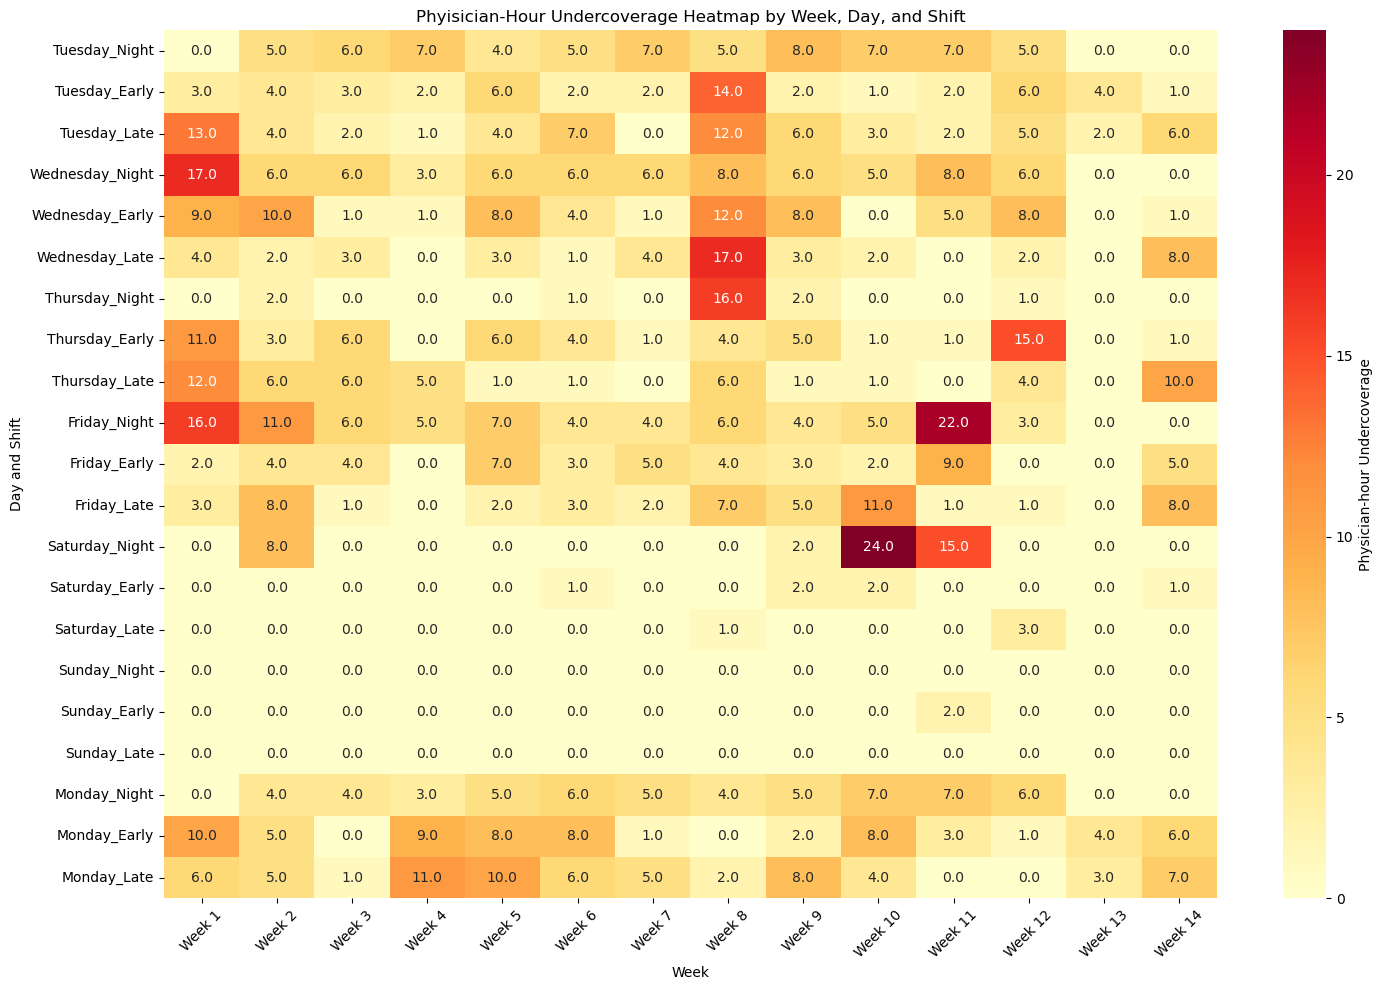

In [45]:
# Define day order starting with Tuesday
day_order = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']
shift_order = ['Night', 'Early', 'Late']

# Convert dictionary to DataFrame
heatmap_data = []
for (week, day, shift), undercoverage in undercoverage_dict.items():
    # Extract week number for proper sorting
    week_num = int(week.split()[1])
    heatmap_data.append({
        'Week': week,
        'Week_Num': week_num,  # Add numerical week for sorting
        'Day': day,
        'Shift': shift,
        'Day_Shift': f"{day}_{shift}",
        'Undercoverage': undercoverage
    })

heatmap_df = pd.DataFrame(heatmap_data)

# Sort by week number
heatmap_df = heatmap_df.sort_values('Week_Num')

# Create all possible Day_Shift combinations in correct order
day_shift_order = [f"{day}_{shift}" for day in day_order for shift in shift_order]

# Pivot and reindex to ensure correct order
heatmap_pivot = heatmap_df.pivot(
    index='Day_Shift',
    columns='Week',
    values='Undercoverage'
)
heatmap_pivot = heatmap_pivot.reindex(day_shift_order)

# Sort columns by week number
week_order = [f"Week {i}" for i in sorted([int(w.split()[1]) for w in heatmap_pivot.columns])]
heatmap_pivot = heatmap_pivot.reindex(columns=week_order)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    heatmap_pivot,
    cmap='YlOrRd',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Physician-hour Undercoverage'},
)

# Customize the plot
plt.title('Phyisician-Hour Undercoverage Heatmap by Week, Day, and Shift')
plt.xlabel('Week')
plt.ylabel('Day and Shift')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Task b)

We now calculate the utilization by adapting the code from task a)

In [46]:
# Iterate over shifts
shifts = demand_hour['ShiftID'].unique()

# Create a dictionary to store the utilization for each week, day, and shift
utilization_dict = {}

for shift in shifts:
    # Average utilization for the shift
    utilization = []
    shift_hours = demand_hour_by_shift.loc[shift]
    
    current_week = shift_hours['Week'].iloc[0]
    current_shift = shift_hours['Shift'].iloc[0].title()
    current_day = shift_hours['DayName'].iloc[0]

    print(f"\n{current_week} - {current_day} - {current_shift}")

    for shift_hour in shift_hours.iterrows():
        demand = shift_hour[1]['PhysiciansNeeded']

        day = shift_hour[1]['DayName']
        shift = shift_hour[1]['Shift'].title()
        physicians_available = schedule_q2.loc[(day, shift)]['count']

        # TODO: Cap resource utilization at 100%?
        utilization.append(demand / physicians_available)
    
    # Take the average utilization for the shift
    utilization_dict[(current_week, current_day, current_shift)] = np.mean(utilization)

    print(f"Utilization: {utilization_dict[(current_week, current_day, current_shift)]*100:.2f}%")
    


Week 1 - Tuesday - Night
Utilization: 50.00%

Week 1 - Tuesday - Early
Utilization: 101.25%

Week 1 - Tuesday - Late
Utilization: 181.25%

Week 1 - Wednesday - Night
Utilization: 206.25%

Week 1 - Wednesday - Early
Utilization: 106.25%

Week 1 - Wednesday - Late
Utilization: 75.00%

Week 1 - Thursday - Night
Utilization: 50.00%

Week 1 - Thursday - Early
Utilization: 108.33%

Week 1 - Thursday - Late
Utilization: 129.17%

Week 1 - Friday - Night
Utilization: 200.00%

Week 1 - Friday - Early
Utilization: 87.50%

Week 1 - Friday - Late
Utilization: 41.67%

Week 1 - Saturday - Night
Utilization: 0.00%

Week 1 - Saturday - Early
Utilization: 12.50%

Week 1 - Saturday - Late
Utilization: 75.00%

Week 1 - Sunday - Night
Utilization: 0.00%

Week 1 - Sunday - Early
Utilization: 0.00%

Week 1 - Sunday - Late
Utilization: 75.00%

Week 1 - Monday - Night
Utilization: 62.50%

Week 1 - Monday - Early
Utilization: 106.25%

Week 1 - Monday - Late
Utilization: 87.50%

Week 2 - Tuesday - Night
Utiliza

Now, print the average utilization throughout all weeks, days and shifts.

In [47]:
# Average utilization
avg_utilization = np.mean(list(utilization_dict.values()))
print(f"\nAverage utilization: {avg_utilization*100:.2f}%")


Average utilization: 66.05%


Let's output the heatmap for better overview

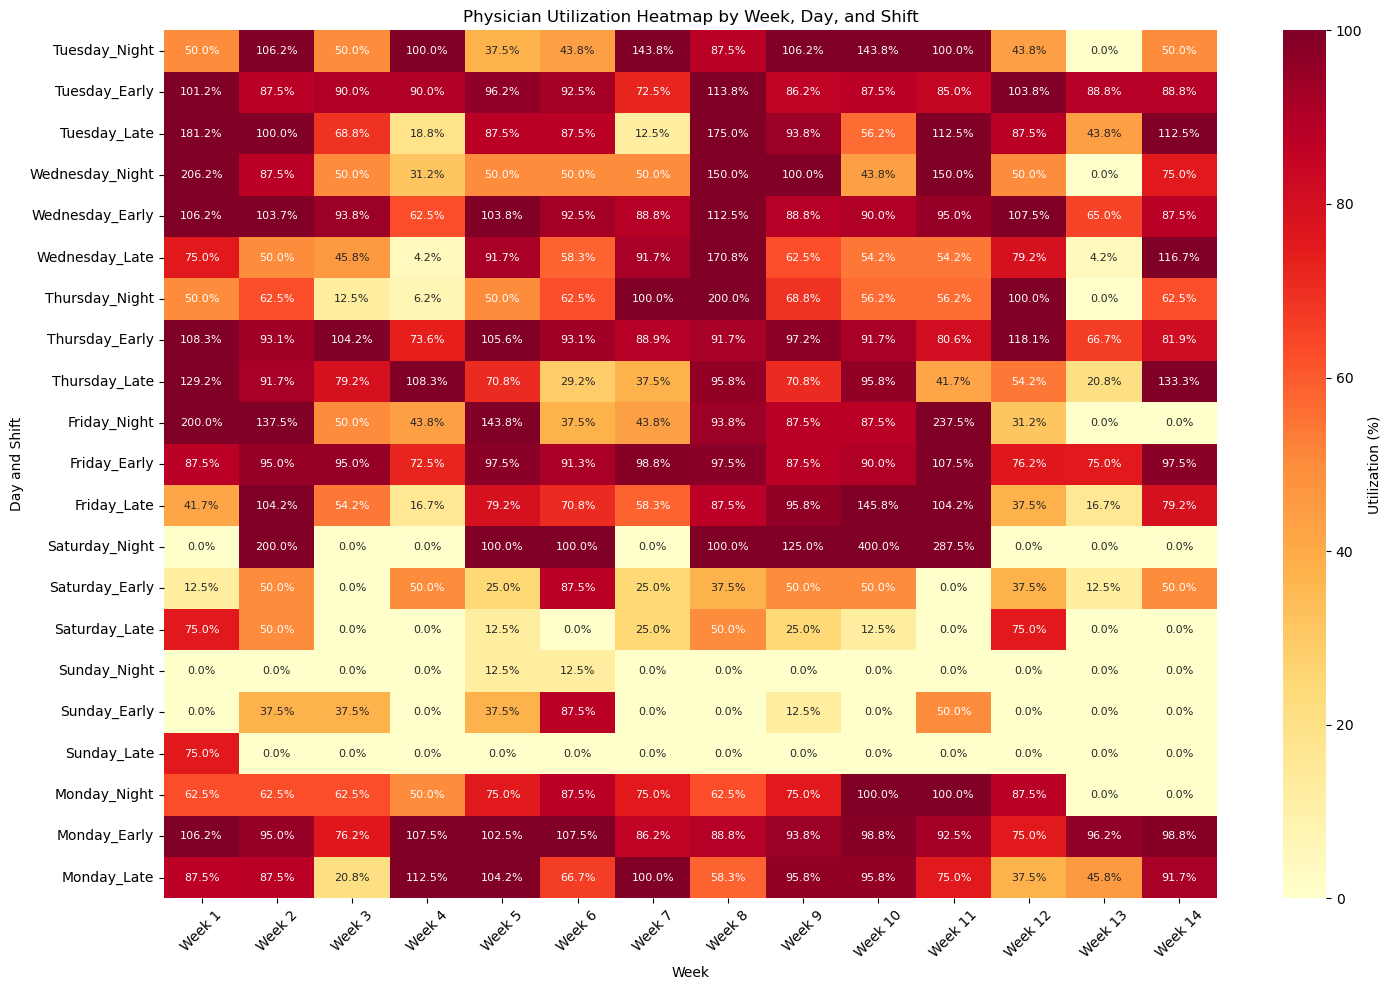

In [48]:
heatmap_data = []
for (week, day, shift), utilization in utilization_dict.items():
    week_num = int(week.split()[1])
    heatmap_data.append({
        'Week': week,
        'Week_Num': week_num,
        'Day': day,
        'Shift': shift,
        'Day_Shift': f"{day}_{shift}",
        'Utilization': utilization * 100  # Multiply by 100 here
    })

heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df = heatmap_df.sort_values('Week_Num')

# Create all possible Day_Shift combinations in correct order
day_shift_order = [f"{day}_{shift}" for day in day_order for shift in shift_order]

# Pivot and reindex to ensure correct order
heatmap_pivot = heatmap_df.pivot(
    index='Day_Shift',
    columns='Week',
    values='Utilization'
)
heatmap_pivot = heatmap_pivot.reindex(day_shift_order)

# Sort columns by week number
week_order = [f"Week {i}" for i in sorted([int(w.split()[1]) for w in heatmap_pivot.columns])]
heatmap_pivot = heatmap_pivot.reindex(columns=week_order)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    heatmap_pivot,
    cmap='YlOrRd',
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 8},
    cbar_kws={'label': 'Utilization (%)'},
    vmin=0,
    vmax=100
)

# Add % symbol to each value
for t in plt.gca().texts:
    t.set_text(t.get_text() + '%')

plt.title('Physician Utilization Heatmap by Week, Day, and Shift')
plt.xlabel('Week')
plt.ylabel('Day and Shift')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Task c)

Please see the results in the next section

### Results

#### Task a)

In the first task a), we simulated the physician-hour undercoverage using the optimized shift plan from Question 2 against the actual demand of physicians needed throughout all weeks, days, and shifts.
We conclude that the total physician-hour undercoverage amounts to 961 physicians.
From the heatmap, it becomes apparent that the undercoverage occurs on weekdays during all shifts, while weekends mostly have an undercoverage of zero.
Furthermore, from Tuesday early to Wednesday night in week eight, the physician-hour undercoverage reaches its peak at 17 physicians.

#### Task b)

In the second task b), we took an alternative approach and analyzed the physician utilization relative to the demand for physicians.
We assumed that resource utilization could exceed 100%.
The average utilization of physicians is 66.05%, meaning 66% of all physicians are utilized on average, while 34% remain available.
While this number seems reasonable, the heatmap shows a similar but more dramatic pattern than the previous heatmap. Most of the time, the utilization is close to 100%, with spikes of up to 400%, indicating that the demand is four times higher than the available physicians.

#### Task c)

The assumption we modified was our approach to rounding up the mean value of physicians needed in question 2. When we used standard rounding, we obtained worse results for both task a) and task b), with a physician-hour undercoverage of approximately 1,437 physicians.
Therefore, we changed our approach by always rounding up the mean value of physicians needed, accepting the cost of one additional physician. This reduced the physician-hour undercoverage by about ~450 physicians and further decreased the physician utilization.

Assumption and its result: The above results demonstrate the physician-hour undercoverage and physician utilization when rounding up the mean demand for physicians, which resulted in lower values for both metrics.

## Question 4 <a name="Question4"></a>

We start by constructing 14 scenarios based on the 14 weeks of provided data. For this purpose we construct a nested dictionary, that represents the weeks on the next level it represents the days within this week and finally the three differnt shift types. 

In [539]:
scenarios = {}

for week, week_group in demand_hour.groupby("Week"):
    scenario_name = week_to_scenario[week]  # Assign scenario based on the week
    scenarios[scenario_name] = {}  # Create scenario entry
    
    # Iterate over days in the week
    for day, day_group in week_group.groupby("DayName"):
        scenarios[scenario_name][day] = {}  # Create day entry
        
        # Iterate over shifts in the day
        for shift, shift_group in day_group.groupby("Shift"):
            # Store the number of doctors needed
            scenarios[scenario_name][day][shift.capitalize()] = int(np.ceil(shift_group["PhysiciansNeeded"].mean()))  

In [540]:
# Print the structured dictionary
import pprint
pprint.pprint(scenarios)

{'scenario_1': {'Friday': {'Early': 9, 'Late': 2, 'Night': 4},
                'Monday': {'Early': 11, 'Late': 3, 'Night': 1},
                'Saturday': {'Early': 1, 'Late': 1, 'Night': 0},
                'Sunday': {'Early': 0, 'Late': 1, 'Night': 0},
                'Thursday': {'Early': 10, 'Late': 4, 'Night': 1},
                'Tuesday': {'Early': 11, 'Late': 4, 'Night': 1},
                'Wednesday': {'Early': 11, 'Late': 3, 'Night': 5}},
 'scenario_10': {'Friday': {'Early': 10, 'Late': 3, 'Night': 3},
                 'Monday': {'Early': 11, 'Late': 4, 'Night': 1},
                 'Saturday': {'Early': 1, 'Late': 1, 'Night': 1},
                 'Sunday': {'Early': 1, 'Late': 0, 'Night': 1},
                 'Thursday': {'Early': 10, 'Late': 3, 'Night': 1},
                 'Tuesday': {'Early': 10, 'Late': 2, 'Night': 1},
                 'Wednesday': {'Early': 11, 'Late': 3, 'Night': 1}},
 'scenario_11': {'Friday': {'Early': 10, 'Late': 3, 'Night': 1},
                 'M

Then we run almost the same programm as in Q2, but this time we inculde stochasticity. We change the deterministic demand constriant to  an expected i.e. stochastic one. 

In [541]:
def physician_scheduling2(physicians, demand, DAYS, SHIFTS):
    sm = gp.Model("PhysicianScheduling")

    # Decision variables
    x = sm.addVars(physicians, DAYS, SHIFTS, vtype=GRB.BINARY, name="x")
    y = sm.addVars(physicians, vtype=GRB.BINARY, name="y")
    b = sm.addVars(physicians, SHIFTS, vtype=GRB.BINARY, name="b")
    day_worked = sm.addVars(physicians, DAYS, vtype=GRB.BINARY, name="day_worked")
    z = sm.addVars(physicians, DAYS, vtype=GRB.BINARY, name="z_consecutiveOff")

    # Objective
    sm.setObjective(gp.quicksum(y[p] for p in physicians), GRB.MINIMIZE)
    
    # Constraints
    # 1. Changed demand Satisfaction constraint
    for d in DAYS:
        for shift in SHIFTS:
            sm.addConstr(
                (gp.quicksum(x[p, d, shift] for p in physicians) + 1) - sum(scenarios[scenario][d][shift] for scenario in nested_dict)/len(nested_dict) >= 0,
                )
            sm.addConstr(
                gp.quicksum(x[p, d, shift] for p in physicians) >= 1,
                name=f"at_least_one_per_shift_{d}_{shift}"
            )

           
    # Ensure y[p] is 1 if physician p works any shift
    for p in physicians:
        sm.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5 * y[p],
            name=f"activate_y_{p}"
        )

    # 2. 40-Hour Weekly Limit
    for p in physicians:
        sm.addConstr(
            gp.quicksum(x[p, d, s] for d in DAYS for s in SHIFTS) <= 5,
            name=f"max_shifts_{p}"
        )

    # 3. Two Shift Types Per Week
    for p in physicians:
        sm.addConstr(
            gp.quicksum(b[p, s] for s in SHIFTS) <= 2,
            name=f"max_shift_types_{p}"
        )
        for d in DAYS:
            for s in SHIFTS:
                sm.addConstr(
                    x[p, d, s] <= b[p, s],
                    name=f"shift_type_assignment_{p}_{d}_{s}"
                )

    # 4. No More Than 3 Consecutive Night Shifts (including cyclic transition)
    for p in physicians:
        for i in range(len(DAYS) - 3):
            sm.addConstr(
                gp.quicksum(x[p, DAYS[i + j], "Night"] for j in range(4)) <= 3,
                name=f"Max3ConsecutiveNights_p{p}_start{i}"
            )
        # Cyclic transition: Friday -> Monday
        sm.addConstr(
            gp.quicksum(x[p, day, "Night"] for day in ["Friday", "Saturday", "Sunday", "Monday", "Tuesday"]) <= 3,
            name=f"Max3ConsecutiveNights_cyclic_p{p}"
        )

    # 5. 10-Hour Rest Requirement (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS)):
            # Maximum one shift per day
            sm.addConstr(
                gp.quicksum(x[p, DAYS[i], s] for s in SHIFTS) <= 1,
                name=f"max_one_shift_per_day_{p}_{DAYS[i]}"
            )

        for i in range(len(DAYS) - 1):
            # Night shift on day i -> No early shift on the next day
            sm.addConstr(
                x[p, DAYS[i], "Night"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"night_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No night shift on the next day
            sm.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"late_to_night_next_day_{p}_{DAYS[i]}"
            )
            # Late shift on day i -> No early shift on the next day
            sm.addConstr(
                x[p, DAYS[i], "Late"] + x[p, DAYS[i + 1], "Early"] <= 1,
                name=f"late_to_early_next_day_{p}_{DAYS[i]}"
            )
            # Early shift on day i -> No night shift on the next day
            sm.addConstr(
                x[p, DAYS[i], "Early"] + x[p, DAYS[i + 1], "Night"] <= 1,
                name=f"early_to_night_next_day_{p}_{DAYS[i]}"
            )

        # Sunday -> Monday transition
        sm.addConstr(
            x[p, "Sunday", "Night"] + x[p, "Monday", "Early"] <= 1,
            name=f"night_to_early_sunday_to_monday_{p}"
        )
        sm.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Night"] <= 1,
            name=f"late_to_night_sunday_to_monday_{p}"
        )
        sm.addConstr(
            x[p, "Sunday", "Late"] + x[p, "Monday", "Early"] <= 1,
            name=f"late_to_early_sunday_to_monday_{p}"
        )
        sm.addConstr(
            x[p, "Sunday", "Early"] + x[p, "Monday", "Night"] <= 1,
            name=f"early_to_night_sunday_to_monday_{p}"
        )

        for d in DAYS:
            sm.addConstr(
                day_worked[p, d] == gp.quicksum(x[p, d, s] for s in SHIFTS),
                name=f"link_day_worked_{p}_{d}"
            )

    # 6. Two Consecutive Days Off (including Sunday -> Monday transition)
    for p in physicians:
        for i in range(len(DAYS) - 1):
            sm.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i]],
                name=f"day_off_constraint_{p}_{DAYS[i]}"
            )
            sm.addConstr(
                z[p, DAYS[i]] <= 1 - day_worked[p, DAYS[i + 1]],
                name=f"consecutive_off_{p}_{DAYS[i]}"
            )
            sm.addConstr(
                z[p, DAYS[i]] >= 1 - (day_worked[p, DAYS[i]] + day_worked[p, DAYS[i + 1]]),
                name=f"force_consecutive_off_{p}_{DAYS[i]}"
            )
        # Ensure cyclic consecutive days off between Sunday and Monday
        sm.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Sunday"],
            name=f"day_off_sunday_{p}"
        )
        sm.addConstr(
            z[p, "Sunday"] <= 1 - day_worked[p, "Monday"],
            name=f"consecutive_off_sunday_monday_{p}"
        )
        sm.addConstr(
            z[p, "Sunday"] >= 1 - (day_worked[p, "Sunday"] + day_worked[p, "Monday"]),
            name=f"force_consecutive_off_sunday_monday_{p}"
        )
        # At least one pair of consecutive days off
        sm.addConstr(
            gp.quicksum(z[p, d] for d in DAYS) >= 1,
            name=f"at_least_one_off_pair_{p}"
        )

    # Solve the model
    sm.optimize()

    return sm, x, y

In [542]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SHIFTS = ["Night", "Early", "Late"]
max_physicians = 21
initial_physicians_sm = range(max_physicians)

sm, x, y = physician_scheduling2(initial_physicians_sm, demand, DAYS, SHIFTS)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 22.6.0 22H221)

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1995 rows, 819 columns and 6552 nonzeros
Model fingerprint: 0xdef6fe99
Variable types: 0 continuous, 819 integer (819 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 9e+00]
Found heuristic solution: objective 21.0000000
Presolve removed 441 rows and 126 columns
Presolve time: 0.19s
Presolved: 1554 rows, 693 columns, 5502 nonzeros
Variable types: 0 continuous, 693 integer (693 binary)

Root relaxation: objective 1.300000e+01, 1723 iterations, 0.21 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.000

In [543]:
if m.status == GRB.OPTIMAL:
    min_physicians_sm = sum(y[p].X for p in initial_physicians_sm)
    print(f"\nMinimum number of physicians required: {int(min_physicians_sm)}")
else:
    print(f"Optimization was unsuccessful. Model status: {sm.status}")


Minimum number of physicians required: 13


Now we check, if the expected undercoverage is below or equl to one for all shifts.

In [544]:
undercoverage = {
    s: {
        d: {
            sh: max(0, scenarios[s][d][sh] - sum(x[p, d, sh].X for p in initial_physicians_sm))
            for sh in SHIFTS
        }
        for d in DAYS
    }
    for s in scenarios
}


In [545]:
expected_undercoverage = {
    d: {
        sh: sum(undercoverage[s][d][sh] for s in scenarios) / len(scenarios)
        for sh in SHIFTS
    }
    for d in DAYS
}


In [546]:
feasible = all(expected_undercoverage[d][sh] <= 1 for d in DAYS for sh in SHIFTS)

if feasible:
    print("✅ Expected physician-hour undercoverage is below or equal to 1 per shift.")
else:
    print("⚠️ Expected physician-hour undercoverage exceeds 1 in some shifts.")


✅ Expected physician-hour undercoverage is below or equal to 1 per shift.


In [547]:
"""
for d in DAYS:
    for sh in SHIFTS:
        if expected_undercoverage[d][sh] >= 1:
            print(f"⚠️ Undercoverage of {expected_undercoverage[d][sh]:.2f} in shift '{sh}' on '{d}'")
"""

'\nfor d in DAYS:\n    for sh in SHIFTS:\n        if expected_undercoverage[d][sh] >= 1:\n            print(f"⚠️ Undercoverage of {expected_undercoverage[d][sh]:.2f} in shift \'{sh}\' on \'{d}\'")\n'

The criterion is met, hence we can produce a schedule. 

In [548]:
# Optimize physician scheduling with the minimum required number of physicians
reduced_physicians_sm = range(int(min_physicians_sm))
m, x, y = physician_scheduling2(reduced_physicians_sm, demand, DAYS, SHIFTS)

print(f"\nOptimized schedule with {min_physicians_sm} physicians.")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 22.6.0 22H221)

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1251 rows, 507 columns and 4056 nonzeros
Model fingerprint: 0x5a9ab12c
Variable types: 0 continuous, 507 integer (507 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 9e+00]
Presolve removed 281 rows and 78 columns
Presolve time: 0.04s
Presolved: 970 rows, 429 columns, 3406 nonzeros
Variable types: 0 continuous, 429 integer (429 binary)

Root relaxation: objective 1.300000e+01, 1145 iterations, 0.17 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.00000    0   52          -   13.00000      -     -  

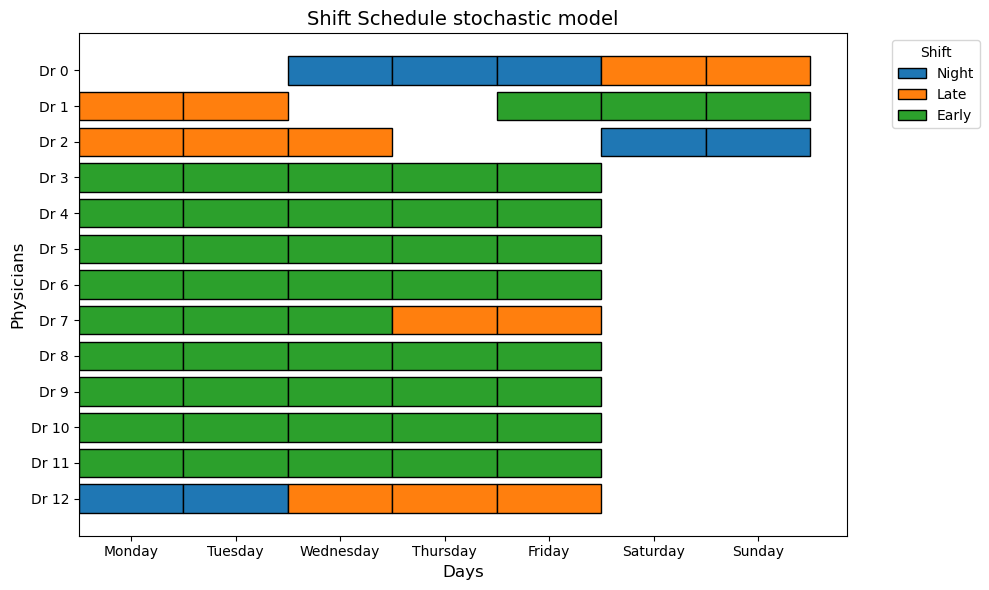

In [549]:
# Create a visual representation of the physician shift schedule
# Gantt diagramm
gantt_data = []
for p in reduced_physicians_sm:
    for d_idx, d in enumerate(DAYS):
        for s in SHIFTS:
            if x[p, d, s].X > 0.5:
                gantt_data.append((f"Dr {p}", d_idx, s))

fig, ax = plt.subplots(figsize=(10, 6))

# Draw bars for each shift
used_labels = set()
for doctor, day_idx, shift in gantt_data:
    label = shift if shift not in used_labels else None
    ax.barh(
        doctor,
        1,
        left=day_idx,
        color=shift_colors[shift],
        edgecolor="black",
        label=label
    )
    used_labels.add(shift)

# Title
ax.set_xlabel("Days", fontsize=12)
ax.set_ylabel("Physicians", fontsize=12)
ax.set_title("Shift Schedule stochastic model", fontsize=14)

ax.set_xticks([i + 0.5 for i in range(len(DAYS))])
ax.set_xticklabels(DAYS, fontsize=10)

ax.set_yticks(range(len(reduced_physicians_sm)))
ax.set_yticklabels([f"Dr {p}" for p in reduced_physicians_sm[::-1]], fontsize=10)

ax.grid(False)

ax.legend(title="Shift", loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

According to our stochastic optimization model the hospital can achieve all the requirments with 13 Physicians. This is a decrease of 3 Physicians - which can reduce costs. This reduction is achieved by incorporating the stochastic demand constraint. All other constraints remain untouched. In addition, you can visually confirm that all conditions are being met.

## Question 5 <a name="Question5"></a>